In [54]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# better display of review text in dataframes
pd.set_option('display.max_colwidth', -1) 

# Seaborn options
sns.set(style="whitegrid", font_scale=1.4)

In [55]:
import tensorflow as tf
assert tf.__version__ >= "2.0"

from tensorflow import keras

In [56]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

# Load data

## Load dataset

In [57]:
import pickle

PICKLE_PATH = "allocine_dataset/data/allocine_dataset.pickle"

with open(PICKLE_PATH, 'rb') as reader:
    data = pickle.load(reader)

# Reviews need to be tokenized
train_reviews = np.array(data["train_set"]['review'])
val_reviews = np.array(data["val_set"]['review'])
test_reviews = np.array(data["test_set"]['review'])
all_reviews = np.concatenate((train_reviews, val_reviews, test_reviews), axis=0)

y_train = np.array(data["train_set"]['polarity'])
y_val = np.array(data["val_set"]['polarity'])
y_test = np.array(data["test_set"]['polarity'])
class_names = data['class_names']

## Tokenize

In [58]:
MAX_NB_WORDS = 20000

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=MAX_NB_WORDS,
    oov_token="<unk>",
    #filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ '
)
tokenizer.fit_on_texts(all_reviews)

word_index = tokenizer.word_index
print("Found {} unique tokens.".format(len(word_index)))

Found 76226 unique tokens.


In [59]:
X_train = tokenizer.texts_to_sequences(train_reviews)
X_val = tokenizer.texts_to_sequences(val_reviews)
X_test = tokenizer.texts_to_sequences(test_reviews)

In [60]:
X_train[0][:15]

[626, 51, 9, 2, 3181, 7752, 4454, 3, 1, 726, 7, 560, 92, 114, 2]

In [61]:
index_to_word = dict((i, w) for w, i in tokenizer.word_index.items())
" ".join([index_to_word[i] for i in X_train[0][:15]])

'tres bon film de romain gavras cassel et <unk> jouent à merveille leur rôle de'

Average length: 109.1
Max length: 723


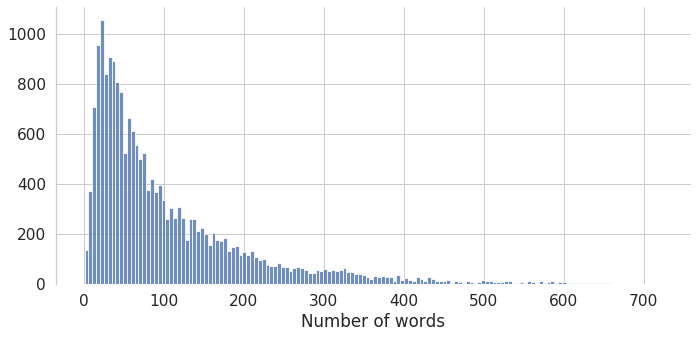

In [62]:
reviews_len = [len(s) for s in X_train+X_val+X_test]
print("Average length: {:.1f}".format(np.mean(reviews_len)))
print("Max length: {}".format(max(reviews_len)))

plt.figure(figsize=(10,5))
ax = sns.distplot(reviews_len, bins=150, kde=False, hist_kws=dict(alpha=0.8))
ax.set(xlabel='Number of words')

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig = ax.get_figure()
fig.savefig('img/word-vectors/number_of_words.png', dpi=200)

In [63]:
reviews_len.count(0) 
# Important not to have empty tensors: https://github.com/tensorflow/tensorflow/issues/33148

0

## Padding

In [64]:
MAX_LENGTH_SEQ = 600

# pad sequence with 0
X_train = tf.keras.preprocessing.sequence.pad_sequences(
    X_train, 
    maxlen=MAX_LENGTH_SEQ,
    padding='post'
)

X_val = tf.keras.preprocessing.sequence.pad_sequences(
    X_val, 
    maxlen=MAX_LENGTH_SEQ,
    padding='post'
)

X_test = tf.keras.preprocessing.sequence.pad_sequences(
    X_test, 
    maxlen=MAX_LENGTH_SEQ,
    padding='post'
)

print('Shape of X_train tensor:', X_train.shape)
print('Shape of X_val tensor:', X_val.shape)
print('Shape of X_test tensor:', X_test.shape)

Shape of X_train tensor: (12000, 600)
Shape of X_val tensor: (4000, 600)
Shape of X_test tensor: (4000, 600)


# Mean embedding

In [21]:
from tensorflow import keras
from tensorflow.keras import layers

EMBEDDING_DIM = 128

model = keras.models.Sequential()
model.add(layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                           input_shape=[None]),)
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [11]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10, batch_size=32, verbose=1)

Train on 11996 samples, validate on 4003 samples
Epoch 1/10
11996/11996 [==============================] - 7s 584us/sample - loss: 0.6789 - accuracy: 0.6128 - val_loss: 0.6480 - val_accuracy: 0.6790
Epoch 2/10
11996/11996 [==============================] - 7s 552us/sample - loss: 0.5998 - accuracy: 0.7709 - val_loss: 0.5446 - val_accuracy: 0.8416
Epoch 3/10
11996/11996 [==============================] - 7s 546us/sample - loss: 0.4910 - accuracy: 0.8487 - val_loss: 0.4564 - val_accuracy: 0.8636
Epoch 4/10
11996/11996 [==============================] - 7s 545us/sample - loss: 0.4045 - accuracy: 0.8805 - val_loss: 0.3939 - val_accuracy: 0.8791
Epoch 5/10
11996/11996 [==============================] - 7s 548us/sample - loss: 0.3423 - accuracy: 0.8974 - val_loss: 0.3523 - val_accuracy: 0.8901
Epoch 6/10
11996/11996 [==============================] - 7s 547us/sample - loss: 0.2952 - accuracy: 0.9136 - val_loss: 0.3291 - val_accuracy: 0.8858
Epoch 7/10
11996/11996 [===========================

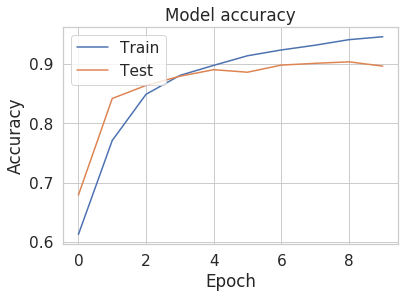

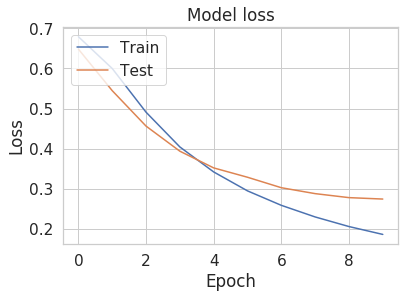

In [12]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [17]:
_, accuracy = model.evaluate(X_val, y_val, verbose=0)
print(accuracy)

0.89607793


# RNN

In [97]:
from tensorflow import keras
from tensorflow.keras import layers

EMBEDDING_DIM = 128

model = keras.models.Sequential()
model.add(layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                           mask_zero=True,                           
                           input_shape=[None]),)

model.add(layers.GRU(128, return_sequences=True))
model.add(layers.GRU(128))
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [98]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5, batch_size=32, verbose=1)

Train on 12000 samples, validate on 4000 samples
Epoch 1/5
12000/12000 [==============================] - 21s 2ms/sample - loss: 0.3937 - accuracy: 0.8203 - val_loss: 0.3048 - val_accuracy: 0.8917
Epoch 2/5
12000/12000 [==============================] - 19s 2ms/sample - loss: 0.1480 - accuracy: 0.9467 - val_loss: 0.2998 - val_accuracy: 0.8850
Epoch 3/5
12000/12000 [==============================] - 19s 2ms/sample - loss: 0.0695 - accuracy: 0.9772 - val_loss: 0.3606 - val_accuracy: 0.8815
Epoch 4/5
12000/12000 [==============================] - 19s 2ms/sample - loss: 0.0356 - accuracy: 0.9874 - val_loss: 0.4586 - val_accuracy: 0.8835
Epoch 5/5
12000/12000 [==============================] - 19s 2ms/sample - loss: 0.0246 - accuracy: 0.9924 - val_loss: 0.5220 - val_accuracy: 0.8773


In [110]:
score, acc = model.evaluate(X_val, y_val,
                            batch_size=32)
print('Test score:', score)
print('Test accuracy:', acc)

4000/4000 [==============================] - 2s 550us/sample - loss: 0.5220 - accuracy: 0.8773
Test score: 0.5220395186692476
Test accuracy: 0.87725


In [186]:
y_score = model.predict(X_val).T[0]
y_pred = model.predict_classes(X_val).T[0]

In [130]:
X_val_df = pd.DataFrame(val_reviews)

In [180]:
false_pos = val_reviews[(y_val == 0) & (y_pred == 1)]
false_neg = val_reviews[(y_val == 1) & (y_pred == 0)]

In [181]:
pd.DataFrame(false_pos[:5])

,0
0,un film qui dépeint assez bien la relation homme femme et la sexualité un bon film psychologique le bémol est il est de taille un film terriblement niais a la limite de la guimauve et c'est bien dommage
1,"Si vous entendez dire qu'il y a Cluzet dans ce téléfilm, c'est vrai, mais attention, fiez-vous plutôt à l'affiche car son rôle n'est pas grand. L'œuvre est aussi modeste que son sujet ; Ledoyen porte bien son personnage de « première femme syndicaliste », mais même elle ne parviendra pas à compenser les textes rédigés sans mesure pour faire bon genre et cohérent dans l'époque. C'est un peu triste car les dialogues sont foncièrement bons et le couple d'acteurs principaux aussi, mais les uns ne sont pas faits pour les autres. Il s'agit peut-être là d'une faiblesse de direction artistique, ou de trop d'ambition dans l'écriture. L'atmosphère est présente quand les figurants ne bâclent pas leurs lignes. La place de l'anticléricalité est bien pensée, et chaque chose semble prendre juste le temps nécessaire pour être prise en compte sans rabâchage. Mais avec du recul, l'image générale est un peu différente ; le scénario évolue par hoquets, les transitions ne se faisant pas le moins du monde les convoyeuses d'un sens global qui aurait survécu d'une scène à une autre. Drame social, petit film qui s'excuse de sa petitesse en se faisant l'honorable documentaire d'une cause naguère dignifiée, il y avait une ligne sur son cahier des charges qui disait : « doit durer quatre-vingt-dix minutes chrono parce que c'est pour la télé ». Il y parvient en donnant honteusement dans le mélodrame avec une conclusion tellement essoufflée qu'elle a besoin d'afficher un encart de texte pour rassurer le spectateur. Au moins le film mesurait-il ce qu'il était, et aussi accomplit-il sa mission sans prétention et avec quelque justesse, mais il demeure, à tous égards, le parangon du télécinéma. septiemeartetdemi.com"
2,"Sans prétentions petit film sympa , on se prend à avoir de l'affection pour nôtre pauvre livreur pas vraiment gâté par la vie et à approuvé son pétage de plomb, qui n'a jamais rêvé d'en faire autant face à des personnes aussi obtus, que hautaines et hautement antiphatiques... bon lui il fait pas dans la dentelle mais l'idée est là. Loin d'être essentiel et ""nanaresque"" il décocheras tout de même quelques sourires(motion spécial pour la scène d'engeuade par le patron.)"
3,Seul les adorateurs de chevaux y trouveront leur compte..
4,"Forêt, fumée noire, mystère...N'est pas ""Lost"" qui veut, surtout en 1h25! Si vous hésitez entre films à regarder, regardez l'autre..."


In [182]:
pd.DataFrame(false_neg[:5])

,0
0,"Ce film vaut surtout pour ses dialogues en français croustillants où les doubleurs ont prit de (très) grandes libertés plus que pour l'histoire, totalement décousue tellement les morceaux de films entrecoupés sont flagrants. Amateurs de dialogues vulgaires, de scénario biaisé, d'armes en plastique et de scènes-références aux films de Sergio Leone, vous serez comblés. Le ""film"", en fait les 11 seules minutes où sont présents les protagonistes américains est facilement trouvable gratuitement sur internet."
1,"Le meilleur de Kounen. Atmosphérique, poétique, un vol d'oiseau sur l'immensité du monde. Poésie des sens, du détail, et pas seulement. D'un coup d'un seul, c'est un genre que l'on transforme pour l'emmener vers là où erre une beauté sans pareil. Quelle aventure."
2,"Ben moi j'ai commencé par ce film et j'ai bien aimé. Faut avouer que els images sont bonnes, tout autant que le maquillage et les effets spéciaux, l'histoire reste géniale, la trame pas si usée. Bref c'est cool, même si certains acteurs sont plus inspirés que d'autres, mais clairement ceux qui font les singes sont au top. Du reste, je ne suis pas persuadé que sans cette daube, comme beaucoup le disent avec leur fameux ""c'était mieux avant"", les reboot auraient vu le jour. On va me dire ""tant mieux"" mais vu le nombre d'entrées je pense qu'il faut réviser son jugement sur ce film. En plus Burton arrive à y imposer sa patte alors que ça ne s'y prêtait pas vraiment. Enfin avouons que l'opus original était moins bien monté que celui-ci, on comprend plus facilement là, un plus non négligeable."
3,"Avant toute chose mieux vaut prévenir les futurs spectateurs : Bienvenue à Marwen n’est pas vraiment une douce fantaisie et encore moins une inoffensive comédie comme pourrait le laisser penser son affiche. S’il trouve néanmoins sa place dans la filmographie de Zemeckis, il faut bien se rendre à l’évidence ça reste un film difficile et franchement assez réaliste (inspiré d’ailleurs d’une histoire vraie) sur le traumatisme et la folie. Bon, cette mise en garde terminée, commençons par reconnaitre les évidentes qualités d’une œuvre qui est réalisée avec beaucoup de soin. Sur le plan technique d’abord, l’animation et les effets spéciaux sont d’excellente facture, sans jamais faire de l’ombre à l’histoire humaine à proprement parler. L’interprétation est toute aussi bonne, Steve Carrel habitant littéralement son personnage dans ce qui pourrait bien être un rôle à Oscar. Bienvenue à Marwen a toutefois un défaut qui est propre à son contenu et donc peut être inévitable. Le côté totalement obsessionnel du personnage principal finit par déteindre sur le film lui- même, le rendant parfois répétitif, oppressant, limite étouffant. A l’image du pauvre Mark Hogancamp, enfermé dans son monde et dans ses délires, on a souvent l’impression de tourner en rond, ressassant la même chose. Mais au final, le film vaut néanmoins largement le coup d'être vu pour son originalité et pour l’émotion qu’il parvient à atteindre dans le dernier quart d’heure. Peut-être pas un happy end, le sujet est trop difficile pour ça, mais pas loin."
4,sans fautes


In [204]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Embedding(MAX_NB_WORDS,
                               output_dim=hp.Int('output_dim',
                                                 min_value=32,
                                                 max_value=128,
                                                 step=32),
                               input_shape=[None]))
    model.add(layers.GlobalAveragePooling1D())
    model.add(layers.Dense(1, activation="sigmoid"))
    
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-3])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='data/keras-tuner',
    project_name='helloworld')

In [210]:
tuner.search_space_summary()

In [ ]:
# TODO !
tuner.search(X_train, y_train, epochs=10,
             validation_data=(X_val, y_val),
             verbose=0)

In [199]:
models = tuner.get_best_models(2)
params = tuner.get_best_hyperparameters(2)

In [201]:
models[0].evaluate(X_val, y_val)

4003/4003 [==============================] - ETA: 4s - loss: 0.2799 - accuracy: 0.81 - ETA: 0s - loss: 0.2725 - accuracy: 0.90 - ETA: 0s - loss: 0.2525 - accuracy: 0.91 - ETA: 0s - loss: 0.2752 - accuracy: 0.90 - ETA: 0s - loss: 0.2730 - accuracy: 0.90 - 0s 64us/sample - loss: 0.2760 - accuracy: 0.9088


[0.2759751172923808, 0.90881836]

In [179]:
tuner.results_summary()